# Imports & Settings

In [1]:
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import loguniform, uniform
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import make_scorer, mean_squared_error as mse, r2_score as r2
from sklearn.model_selection import cross_validate, learning_curve, train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import  OneHotEncoder, PolynomialFeatures, RobustScaler, StandardScaler

In [2]:
# Enable diagrams to visualize pipelines
from sklearn import set_config
set_config(display="diagram")

# Functions

In [3]:
def plot_learning_curves(model,
                         metric = "r2", cv: int = 10,
                         out: bool = False) -> None:
    """
    `out` set to True allows to export the graph in png format
    in the viz/graphs folder.
    """
    # the estimator is the pipeline's last element
    model_name = model[-1].__class__.__name__
    # in case of custom estimator, get its __name__ attribute
    try:
        metric_name = metric.__name__
    except AttributeError:
        metric_name = metric
    
    train_sizes, train_scores, test_scores = learning_curve(
        model,
        X_train, y_train,
        train_sizes=np.linspace(0.1, 1.0, 10), # 10 train sizes with cumulative 10%
        cv=cv,
        scoring=metric, # Default None. str
        n_jobs=-1,
        return_times=False # Switch if you want fit and score times
    )

    # take the mean of cross-validated train score and validation score
    # if scores are negative, take the absolute value
    train_scores_means = np.abs(np.mean(train_scores, axis=1))
    test_scores_means = np.abs(np.mean(test_scores, axis=1))

    # plotting
    plt.figure(figsize=(12, 6))
    plt.plot(train_sizes, train_scores_means, label="Training Score")
    plt.plot(train_sizes, test_scores_means, label="Validation Score")
    plt.ylabel(f"{metric_name} Score", size="large", weight="bold")
    plt.xlabel("Training Set Size", size="large", weight="bold")
    plt.title(f"Learning Curves for {model_name} with {metric_name}",
              size="x-large", weight="bold", c="b")
    plt.grid(ls="--")
    plt.legend(loc="best")

    if out:
        plt.savefig(f"viz/graphs/lc_{model_name}_{metric}.png", dpi=300)
        
    plt.show()

In [4]:
def rmse_scorer(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

In [5]:
def split_bmi_in_three(x: float) -> str:
    if x < 25:
        return "underweight_normal"
    if x < 30:
        return "overweight"
    return "obesity"

# Data Loading & Separating

In [6]:
df = pd.read_csv("csvs/cleaned_dataset.csv")

In [7]:
y = df.pop("charges")
X = df

# Preprocessing

## Modifying `y`'s Shape

<font color="orangered">**On EDA's notebook §9 was showed the target's skewness, here's to correct it.**

In [8]:
y = np.log(y + 1)

## Preprocessing 1

> 👉 <font color="orangered">**We'll scale our three numerical variables, as it is, theoretically,  > better in order to use a linear model.**</font>
>
> PS: There's still a doubt about considering or not `bmi`, which is continuous, as a nominal variable. If there's time and room to use both approaches, then it will be done later.

In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 62.8+ KB


### Hold-Out 1

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=True,
                                                    train_size=0.85,
                                                    random_state=42,
                                                    stratify=X['smoker'])

### Pipe 1

In [11]:
num_cols_1 = X.select_dtypes(exclude="object").columns
bin_cols = ["sex", "smoker"]
ohe_cols_1 = ["region"]

In [12]:
num_cols_1, bin_cols, ohe_cols_1

(Index(['age', 'bmi', 'children'], dtype='object'),
 ['sex', 'smoker'],
 ['region'])

In [13]:
preproc_1 = ColumnTransformer([
    ("num", StandardScaler(), num_cols_1),
    ("bin", OneHotEncoder(drop="if_binary", handle_unknown="ignore"), bin_cols),
    ("ohe", OneHotEncoder(drop="first", handle_unknown="ignore"), ohe_cols_1)
])

In [14]:
preproc_1

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 Index(['age', 'bmi', 'children'], dtype='object')),
                                ('bin',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore'),
                                 ['sex', 'smoker']),
                                ('ohe',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 ['region'])])

## Preprocessing 2

### Bucketizing `bmi`

☝️ <font color="orangered">**First of all, we will transform `bmi` into a nominal variable.**</font>

In [15]:
X_bmi_nom = X.copy()

In [16]:
X_bmi_nom.bmi = X_bmi_nom.bmi.apply(split_bmi_in_three)
X_bmi_nom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       1337 non-null   int64 
 1   sex       1337 non-null   object
 2   bmi       1337 non-null   object
 3   children  1337 non-null   int64 
 4   smoker    1337 non-null   object
 5   region    1337 non-null   object
dtypes: int64(2), object(4)
memory usage: 62.8+ KB


In [17]:
X_bmi_nom.bmi.value_counts(normalize=True)

bmi
obesity               0.528048
overweight            0.288706
underweight_normal    0.183246
Name: proportion, dtype: float64

### Holt-Out 2

In [18]:
X_bmi_nom_train, X_bmi_nom_test, y_train, y_test =\
train_test_split(X_bmi_nom, y,
                 shuffle=True,
                 train_size=0.85,
                 random_state=42,
                 stratify=X['smoker'])

In [19]:
num_cols_2 = ["age", "children"]
ohe_cols_2 = ["bmi", "region"]

In [20]:
preproc_2 = ColumnTransformer([
    ("num", StandardScaler(), num_cols_2),
    ("bin", OneHotEncoder(drop="if_binary", handle_unknown="ignore"), bin_cols),
    ("ohe", OneHotEncoder(drop="first", handle_unknown="ignore"), ohe_cols_2)
])

In [21]:
preproc_2

ColumnTransformer(transformers=[('num', StandardScaler(), ['age', 'children']),
                                ('bin',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore'),
                                 ['sex', 'smoker']),
                                ('ohe',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 ['bmi', 'region'])])

# Adding Estimators to End Pipelines

In [22]:
pipe_1_lr = make_pipeline(preproc_1, LinearRegression())
pipe_1_en = make_pipeline(preproc_1, ElasticNet(random_state=42))

pipe_2_lr = make_pipeline(preproc_2, LinearRegression())
pipe_2_en = make_pipeline(preproc_2, ElasticNet(random_state=42))

In [23]:
pipe_1_lr

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['age', 'bmi', 'children'], dtype='object')),
                                                 ('bin',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['sex', 'smoker']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['region'])])),
                ('linearregression', LinearRegression())])

In [24]:
pipe_1_en

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['age', 'bmi', 'children'], dtype='object')),
                                                 ('bin',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['sex', 'smoker']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['region'])])),
                ('elasticnet', ElasticNet(random_state=42))])

In [25]:
pipe_2_lr

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'children']),
                                                 ('bin',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['sex', 'smoker']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['bmi', 'region'])])),
                ('linearregression', LinearRegression())])

In [26]:
pipe_2_en

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'children']),
                                                 ('bin',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['sex', 'smoker']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['bmi', 'region'])])),
                ('elasticnet', ElasticNet(random_state=42))])

# Raw Cross-Validation

## 🚸 `StratifiedKFold` Implementation

> **MOTIVATION**
>
> We previously took care to stratify `smoker` in *test* set.
>
> We now have to take care to stratify it in *train* set too.
>
> In order to do that, we can create a `FeatureStratifiedKFold` class, based upon `StratifiedKFold`.

In [27]:
# class FeatureStratifiedKFold:
#     def __init__(self,
#                  n_splits: int = 10, shuffle: bool = True,
#                  random_state: Optional[int] = None):
#         self.n_splits = n_splits
#         self.shuffle = shuffle
#         self.random_state = random_state

#     def split(self, X, y=None):
#         stratity_by = X["smoker"]
#         sfk = StratifiedKFold(n_splits=self.n_splits, 
#                               shuffle=self.shuffle,
#                               random_state=self.random_state)
#         return skf.split(X, stratify_by)

#     def get_n_splits(self, X=None, y=None):
#         return self.n_splits

In [28]:
# feature_stratified_cv = FeatureStratifiedKFold(random_state=42)

In [29]:
def cross_val(model, X_train) -> pd.DataFrame:
    results = cross_validate(
        model,
        X_train, y_train,
        cv=10,
        scoring="r2",
        n_jobs=-1
    )
    return pd.DataFrame(results)

## `LinearRegression` with preprocessing 1

### Trainings and Results

In [30]:
%%time
cross_val(pipe_1_lr, X_train)

CPU times: user 58 ms, sys: 144 ms, total: 202 ms
Wall time: 1.21 s


,fit_time,score_time,test_score
0,0.054999,0.075715,0.654832
1,0.018326,0.081746,0.811772
2,0.052803,0.080788,0.769860
3,0.016399,0.067976,0.771066
4,0.010711,0.073549,0.691802
5,0.031245,0.073527,0.843344
6,0.026318,0.084231,0.727097
7,0.034858,0.082877,0.736192
8,0.019023,0.083008,0.755025
9,0.014560,0.082653,0.654486


### Score on train set

In [31]:
pipe_1_lr.fit(X_train, y_train)
pipe_1_lr.score(X_test, y_test)

0.8404852830432452

## `ElasticNet` with preprocessing 1

### Trainings and Results

In [32]:
cross_val(pipe_1_en, X_train)

,fit_time,score_time,test_score
0,0.008839,0.058108,-0.001118
1,0.013428,0.062409,-0.007625
2,0.010617,0.042360,-0.006776
3,0.009098,0.038885,-0.000694
4,0.009128,0.041451,-0.060108
5,0.009800,0.042747,-0.009554
6,0.016923,0.007816,-0.004785
7,0.016089,0.007533,-0.016696
8,0.015306,0.007595,-0.153869
9,0.015658,0.008001,-0.033521


### Score on test set

In [33]:
pipe_1_en.fit(X_train, y_train)
pipe_1_en.score(X_test, y_test)

-0.0050196621004052755

## `LinearRegression` with preprocessing 2

## Training and Results

In [34]:
cross_val(pipe_2_lr, X_bmi_nom_train)

,fit_time,score_time,test_score
0,0.011573,0.004957,0.659968
1,0.010645,0.004846,0.815449
2,0.011034,0.006712,0.772178
3,0.013193,0.008242,0.774092
4,0.013861,0.006558,0.673376
5,0.013011,0.005124,0.840828
6,0.013638,0.004839,0.734843
7,0.012094,0.006705,0.742840
8,0.012175,0.006506,0.748173
9,0.013895,0.004496,0.654622


### Score on test set

In [35]:
pipe_2_lr.fit(X_bmi_nom_train, y_train)
pipe_2_lr.score(X_bmi_nom_test, y_test)

0.8378143476270324

## `ElasticNet` with preprocessing 2

### Training and Results

In [36]:
cross_val(pipe_2_en, X_bmi_nom_train)

,fit_time,score_time,test_score
0,0.040878,0.004400,-0.001118
1,0.011981,0.047278,-0.007625
2,0.014583,0.005385,-0.006776
3,0.033100,0.004400,-0.000694
4,0.011959,0.004745,-0.060108
5,0.009736,0.004284,-0.009554
6,0.009735,0.004345,-0.004785
7,0.009957,0.005296,-0.016696
8,0.008241,0.003146,-0.153869
9,0.008009,0.003190,-0.033521


### Score on test set

In [37]:
pipe_2_en.fit(X_bmi_nom_train, y_train)
pipe_2_en.score(X_bmi_nom_test, y_test)

-0.0050196621004052755

# Full pipe with `PolynomialFeatures`

## Pipelines

In [38]:
X_bmi_nom

,age,sex,bmi,children,smoker,region
0,19,female,overweight,0,yes,southwest
1,18,male,obesity,1,no,southeast
2,28,male,obesity,3,no,southeast
3,33,male,underweight_normal,0,no,northwest
4,32,male,overweight,0,no,northwest
...,...,...,...,...,...,...
1332,50,male,obesity,3,no,northwest
1333,18,female,obesity,0,no,northeast
1334,18,female,obesity,0,no,southeast
1335,21,female,overweight,0,no,southwest


In [39]:
ohe_cols = ["bmi", "region"]
bin_cols = ["sex", "smoker"]

In [40]:
encoder = ColumnTransformer([
    ("bin", OneHotEncoder(drop="if_binary", handle_unknown="ignore"), bin_cols),
    ("ohe", OneHotEncoder(drop="first", handle_unknown="ignore"), ohe_cols)
], remainder="passthrough")

In [41]:
encoder

ColumnTransformer(remainder='passthrough',
                  transformers=[('bin',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore'),
                                 ['sex', 'smoker']),
                                ('ohe',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 ['bmi', 'region'])])

In [42]:
poly = PolynomialFeatures(degree=2)
std = StandardScaler()
en = ElasticNet(random_state=42, max_iter=10_000, tol=1e-3)
lr = LinearRegression()

In [43]:
full_pipe_en = make_pipeline(
    encoder,
    poly,
    std,
    en
)    

In [44]:
full_pipe_en

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('bin',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['sex', 'smoker']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['bmi', 'region'])])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('elasticnet',
                 ElasticNet(max_iter=10000, random_state=42, tol=0.001))])

In [45]:
full_pipe_lr = make_pipeline(
    encoder,
    poly,
    std,
    lr
)    

In [46]:
full_pipe_lr

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('bin',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['sex', 'smoker']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['bmi', 'region'])])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

## `ElasticNet` training

In [47]:
%%time

params = {
    "elasticnet__alpha": uniform(0, 1),
    "elasticnet__l1_ratio": uniform(0, 1)
}

n_iter = 2_000

random_search = RandomizedSearchCV(
    full_pipe_en,
    param_distributions=params,
    n_iter=n_iter,
    cv=10,
    n_jobs=-1
)

random_search.fit(X_bmi_nom_train, y_train)

CPU times: user 23.4 s, sys: 1.06 s, total: 24.4 s
Wall time: 30.9 s


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('bin',
                                                                               OneHotEncoder(drop='if_binary',
                                                                                             handle_unknown='ignore'),
                                                                               ['sex',
                                                                                'smoker']),
                                                                              ('ohe',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore'),
                                                                               ['bmi',
                                                                                'region'])])),
                                             ('polynomialfeatures',
                                              PolynomialFeatures()),
                                             ('standardscaler',
                                              StandardScaler()),
                                             ('elasticnet',
                                              ElasticNet(max_iter=10000,
                                                         random_state=42,
                                                         tol=0.001))]),
                   n_iter=2000, n_jobs=-1,
                   param_distributions={'elasticnet__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f1883f134d0>,
                                        'elasticnet__l1_ratio': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f1883f208d0>})

In [48]:
best_model = random_search.best_estimator_
best_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('bin',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['sex', 'smoker']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['bmi', 'region'])])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('elasticnet',
                 ElasticNet(alpha=0.0017508840741660148,
                            l1_ratio=0.21975907958331886, max_iter=10000,
                            random_state=42, tol=0.001))])

## `ElasticNet` score

In [49]:
best_model.fit(X_bmi_nom_train, y_train)
best_model.score(X_bmi_nom_test, y_test)

0.9162659523174624

## `ElasticNet` coefficients

In [50]:
coefs = best_model[-1].coef_

feats = best_model[:-1].get_feature_names_out()

scores = {feat: coef for feat, coef in zip(feats, coefs)}

(pd.DataFrame(scores, index=["coef"])
 .T
 .sort_values(by="coef", key=lambda x: abs(x), ascending=False)
)

,coef
bin__smoker_yes,0.723192
remainder__age,0.611118
bin__smoker_yes remainder__age,-0.524767
bin__smoker_yes^2,0.489933
remainder__children,0.363020
remainder__age remainder__children,-0.176619
bin__smoker_yes ohe__bmi_underweight_normal,-0.141770
ohe__region_southeast remainder__age,0.139555
bin__smoker_yes ohe__bmi_overweight,-0.133331
ohe__region_southeast,-0.117772


## `LinearRegression` training

In [51]:
%%time
cross_val(full_pipe_lr, X_bmi_nom_train)

CPU times: user 262 ms, sys: 991 ms, total: 1.25 s
Wall time: 110 ms


,fit_time,score_time,test_score
0,0.019673,0.007382,0.734750
1,0.015723,0.004196,0.874086
2,0.011787,0.004009,0.815013
3,0.009726,0.003375,0.851296
4,0.008927,0.003949,0.739207
5,0.008242,0.003563,0.907669
6,0.008435,0.003482,0.838420
7,0.008714,0.003623,0.797334
8,0.008508,0.003362,0.840284
9,0.008961,0.003183,0.735789


## `LinearRegression` score

In [52]:
full_pipe_lr.fit(X_bmi_nom_train, y_train)
full_pipe_lr.score(X_bmi_nom_test, y_test)

0.9196539288631895

## `LinearRegression` coefficients

In [53]:
coefs = full_pipe_lr[-1].coef_
feats = full_pipe_lr[:-1].get_feature_names_out()
scores = {feat: coef for feat, coef in zip(feats, coefs)}

(pd.DataFrame(scores, index=["coef"])
 .T
 .sort_values(by="coef", key=lambda x: abs(x), ascending=False)
)

,coef
ohe__bmi_overweight^2,-3.737949e+12
ohe__bmi_overweight,3.737949e+12
bin__smoker_yes,2.750871e+12
bin__smoker_yes^2,-2.750871e+12
bin__sex_male^2,-1.434014e+12
bin__sex_male,1.434014e+12
ohe__region_northwest^2,-8.475406e+10
ohe__region_northwest,8.475406e+10
ohe__region_southeast^2,-6.848567e+10
ohe__region_southeast,6.848567e+10


## Residuals

In [54]:
y_train_pred = full_pipe_lr.predict(X_bmi_nom_train)

residuals = y_train - y_train_pred
residuals

1094   -0.404428
94      0.137892
349    -0.279766
410    -0.267602
981    -0.014564
          ...   
674    -0.016521
752    -0.177684
319    -0.229696
934    -0.157587
1113   -0.133004
Name: charges, Length: 1136, dtype: float64

### Residuals Distribution

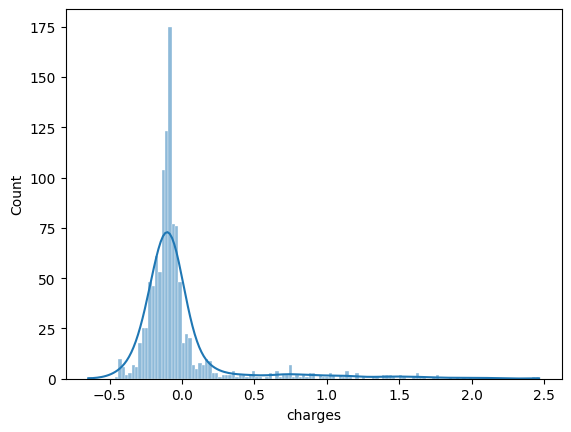

In [55]:
sns.histplot(residuals, kde=True, edgecolor="w")
plt.show()

<font color="orangered">**It seems the residuals are not normally distributed.**</font>

### Residuals vs Fitted

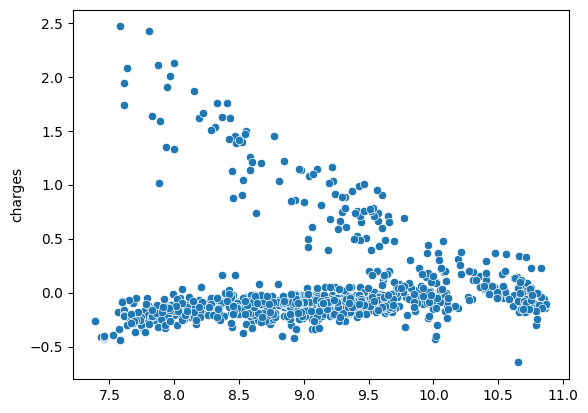

In [56]:
sns.scatterplot(x=y_train_pred, y=residuals)
plt.show()

<font color="orangered">**They don't seem to be of equal variance.**</font>

# Robust Scaling

In [57]:
rob = RobustScaler()

In [58]:
rob_pipe_lr = make_pipeline(
    encoder,
    poly,
    rob,
    lr
)
rob_pipe_lr

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('bin',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['sex', 'smoker']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['bmi', 'region'])])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('robustscaler', RobustScaler()),
                ('linearregression', LinearRegression())])

In [59]:
rob_pipe_en = make_pipeline(
    encoder,
    poly,
    rob,
    en
)    
rob_pipe_en

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('bin',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['sex', 'smoker']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['bmi', 'region'])])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('robustscaler', RobustScaler()),
                ('elasticnet',
                 ElasticNet(max_iter=10000, random_state=42, tol=0.001))])

## `LinearRegression` Training

In [60]:
%%time
cross_val(rob_pipe_lr, X_bmi_nom_train)

CPU times: user 27.4 ms, sys: 8.23 ms, total: 35.7 ms
Wall time: 65 ms


,fit_time,score_time,test_score
0,0.028296,0.004898,0.733168
1,0.028588,0.006648,0.873848
2,0.024938,0.005937,0.817529
3,0.024985,0.005990,0.852948
4,0.025075,0.005684,0.740656
5,0.028019,0.009628,0.910733
6,0.027917,0.007924,0.839681
7,0.029208,0.007883,0.804394
8,0.027822,0.006832,0.842495
9,0.030535,0.005498,0.736842


## `LinearRegression` Score

In [61]:
rob_pipe_lr.fit(X_bmi_nom_train, y_train)
rob_pipe_lr.score(X_bmi_nom_test, y_test)

0.9179762041725038

## `ElasticNet` training

In [62]:
%%time

params = {
    "elasticnet__alpha": uniform(0, 1),
    "elasticnet__l1_ratio": uniform(0, 1)
}

n_iter = 2_000

random_search = RandomizedSearchCV(
    rob_pipe_en,
    param_distributions=params,
    n_iter=n_iter,
    cv=10,
    n_jobs=-1
)

random_search.fit(X_bmi_nom_train, y_train)

/home/greg/projects/PolicyPriceAI/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.255e+01, tolerance: 8.570e-01
  model = cd_fast.enet_coordinate_descent(
/home/greg/projects/PolicyPriceAI/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.049e+00, tolerance: 8.600e-01
  model = cd_fast.enet_coordinate_descent(
/home/greg/projects/PolicyPriceAI/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

CPU times: user 32.9 s, sys: 2.69 s, total: 35.6 s
Wall time: 50 s


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('bin',
                                                                               OneHotEncoder(drop='if_binary',
                                                                                             handle_unknown='ignore'),
                                                                               ['sex',
                                                                                'smoker']),
                                                                              ('ohe',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore'),
                                                                               ['bmi',
                                                                                'region'])])),
                                             ('polynomialfeatures',
                                              PolynomialFeatures()),
                                             ('robustscaler', RobustScaler()),
                                             ('elasticnet',
                                              ElasticNet(max_iter=10000,
                                                         random_state=42,
                                                         tol=0.001))]),
                   n_iter=2000, n_jobs=-1,
                   param_distributions={'elasticnet__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f188344e3d0>,
                                        'elasticnet__l1_ratio': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f188353a1d0>})

## `ElasticNet` score

In [63]:
rob_pipe_en.fit(X_bmi_nom_train, y_train)
rob_pipe_en.score(X_bmi_nom_test, y_test)

0.47111421283209076

## Residuals

In [64]:
y_train_pred = rob_pipe_lr.predict(X_bmi_nom_train)

residuals = y_train - y_train_pred
residuals

1094   -0.406142
94      0.150314
349    -0.243671
410    -0.258529
981    -0.184955
          ...   
674    -0.016570
752    -0.210304
319    -0.211596
934    -0.145413
1113   -0.137979
Name: charges, Length: 1136, dtype: float64

### Residuals Distribution

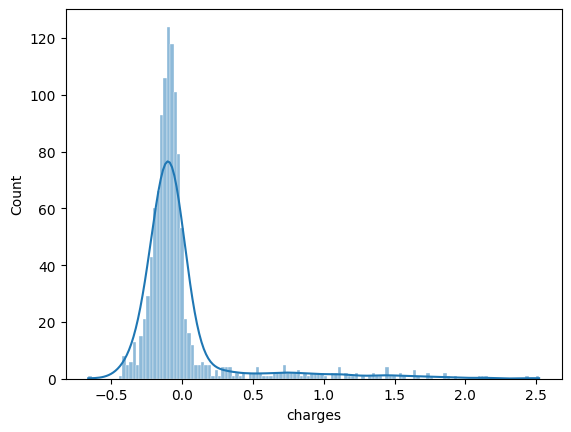

In [65]:
sns.histplot(residuals, kde=True, edgecolor="w")
plt.show()

### Residuals vs Fitted

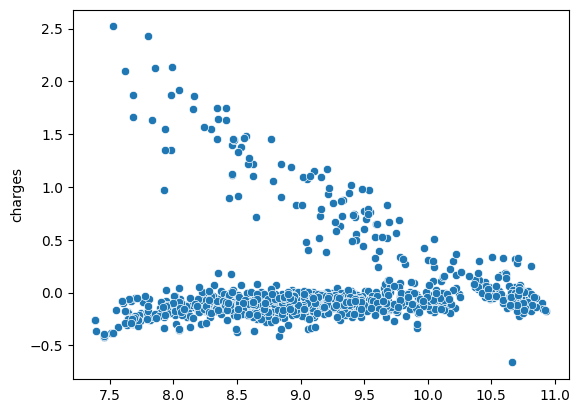

In [66]:
sns.scatterplot(x=y_train_pred, y=residuals)
plt.show()

<font color="orangered">**It seems using `RobustScaler` didn't solve heteroscedasticity.**</font>